In [118]:
## IMPORTS

# BASE
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

# MACHINE LEARNING
from sklearn.model_selection import train_test_split, learning_curve
# Models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
## Hyperparameter Tuning
from scipy.stats import randint
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, TimeSeriesSplit

# PROJECT MODULES
import models_utils

In [119]:
## HYPERPARAMETER TUNING

def perform_search(model, params, X_train, y_train, X_test, y_test, search_type='random'):
    tscv = TimeSeriesSplit(n_splits=3)
    
    if search_type == 'random':
        search = RandomizedSearchCV(model, param_distributions=params, n_iter=200, scoring='neg_mean_squared_error', n_jobs=-1, cv=tscv)
    elif search_type == 'grid':
        search = GridSearchCV(model, param_grid=params, scoring='neg_mean_squared_error', n_jobs=-1, cv=tscv)
    else:
        raise ValueError("Invalid search_type. Use 'random' or 'grid'.")
    
    model_search = search.fit(X_train, y_train)

    print('Best hyperparameters are: ' + str(model_search.best_params_))
    print('Best score is: ' + str(model_search.best_score_))

    model = model_search.best_estimator_
    model.fit(X_train, y_train)
    
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    mae = mean_absolute_error(y_test, pred)
    print('MSE:', mse)
    print('MAE:', mae)
    
    train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv=tscv, scoring='neg_mean_squared_error')

    return model, train_sizes, train_scores, test_scores

In [120]:
## CHARTS and UTILS

tscv = TimeSeriesSplit(n_splits=3)

def get_model_feature_importances(model, feature_names):
    feature_importances = model.feature_importances_
    feature_importances_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances_df.sort_values(by='importance', ascending=False, inplace=True)
    feature_importances_df.set_index('feature', inplace=True, drop=True)
    return feature_importances_df


def plot_learning_curve(model, X, y, cv, train_sizes=np.linspace(0.1, 1.0, 10), scoring='neg_mean_squared_error'):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=cv, train_sizes=train_sizes, scoring=scoring, n_jobs=-1
    )

    train_scores_mean = -np.mean(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)

    plt.figure(figsize=(8, 4))
    plt.plot(train_sizes, train_scores_mean, label='Training error')
    plt.plot(train_sizes, test_scores_mean, label='Validation error')
    plt.xlabel('Training examples')
    plt.ylabel(f'Negative {scoring.capitalize()}')  # Adjust the ylabel based on your scoring metric
    plt.title('Learning Curve')
    plt.legend(loc='best')
    plt.show()

def plot_feature_importances(feature_importances, feature_names):
    # Sort feature importances in descending order
    sorted_idx = np.argsort(feature_importances)[::-1]
    # Plot the top 20 most important features
    plt.figure(figsize=(10, 6))
    plt.bar(range(20), feature_importances[sorted_idx][:20], align='center')
    plt.xticks(range(20), feature_names[sorted_idx][:20], rotation=45)
    plt.xlabel('Feature')
    plt.ylabel('Importance')
    plt.title('Top 20 Feature Importances')
    plt.show()

def remove_low_importance_features(feature_importances, threshold=0.01):
    # Assuming feature_importances is a pandas Series
    selected_features = feature_importances[feature_importances >= threshold].index
    return selected_features

In [121]:
## OPEN FILE

lots = pd.read_csv('../clean-files/catalogo_artworks_info.csv', index_col=0)
lots.drop(columns=['Error', '0', '0.1', '0.2', '0.3', '0.4'], inplace=True)

lots = lots[lots['Medium_type'] != 'outro']

In [122]:
## SELECT ARTISTS

catalogo_artists = [
    'José Pancetti - Giuseppe Gianinni Pancetti - Jose Pancetti',
    'Candido Portinari (1903-1962)',
    'Di Cavalcanti (1897-1976)',
    'Alberto Guignard - Alberto da Veiga Guignard',
    'Antônio Bandeira (1922-1967)',
    'Ismael Nery',
    'Tarsila do Amaral',
    'Maria Martins',
    'Maria Leontina Franco Da Costa',
    'Djanira da Motta e Silva',
    'Ibere Camargo - Iberê Camargo',
    'Milton Dacosta',
    'Cildo Meireles (1948)',
    'Helio Oiticica - Hélio Oiticica',
    'Annita Catarina Malfatti - Anita Malfatti - Anita Malfati',
]

lots = lots[lots['Artist'].isin(catalogo_artists)]

In [123]:
## DROP OUTLIERS (BRL/cm² > 0.9 percentile and < 0.1 percentile)

# for each medium_type, remove outliers: lots with price / area > 0.9 percentile
for medium_type in lots['Medium_type'].unique():
    medium_type_lots = lots[lots['Medium_type'] == medium_type]
    medium_type_lots = medium_type_lots[medium_type_lots['Price (BRL/cm²)'] < medium_type_lots['Price (BRL/cm²)'].quantile(0.9)]
    medium_type_lots = medium_type_lots[medium_type_lots['Price (BRL/cm²)'] > medium_type_lots['Price (BRL/cm²)'].quantile(0.1)]
    print(medium_type, len(medium_type_lots))
    lots = pd.concat([lots[lots['Medium_type'] != medium_type], medium_type_lots])

desenho 2315
reprodução 2040
pintura 4744


In [124]:
## ONLY PAINTINGS
# lots = lots[lots['Medium_type'] == 'pintura']

In [125]:
## GET DF TO MODEL
X_train, X_test, y_train, y_test = models_utils.get_df_to_model(lots)

feature_names = X_train.columns
tscv = TimeSeriesSplit(n_splits=3)

shape of lots_to_model (before split): (9099, 6)
model features: 19


Best hyperparameters are: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 75}
Best score is: -3798723139.8666744
MSE: 2575072197.932833
MAE: 12614.864011150174


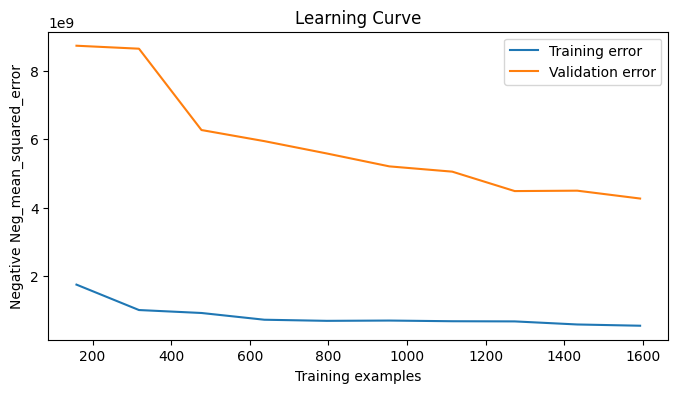

,importance
feature,
Height (cm),0.326970
Width (cm),0.301138
Year of sale,0.113832
Medium_type_pintura,0.065452
Artist_Di Cavalcanti (1897-1976),0.051770
Artist_Antônio Bandeira (1922-1967),0.033880
Artist_Djanira da Motta e Silva,0.029373
Medium_type_reprodução,0.025798
Artist_Candido Portinari (1903-1962),0.015061


In [126]:
# Random Forest
rf = RandomForestRegressor()
rf_params = {
    'max_depth': np.arange(10, 510, step=50),
    'n_estimators': np.arange(60, 80, step=5),
    'min_samples_leaf': np.arange(1, 3, step=1),
    'min_samples_split': np.arange(1, 3, step=1)
}

rf_model, rf_train_sizes, rf_train_scores, rf_test_scores = perform_search(rf, rf_params, X_train, y_train, X_test, y_test, search_type='random')
rf_feature_importances = rf_model.feature_importances_

plot_learning_curve(rf_model, X_train, y_train, cv=tscv)
rf_feature_importances_df = get_model_feature_importances(rf_model, feature_names)
rf_feature_importances_df

In [127]:
## TRAINING MODEL WITH SELECTED FEATURES (feature importance > 0.01)

# rf_feature_importances_df = get_model_feature_importances(rf_model, feature_names)
# rf_feature_importances_df
# selected_features = remove_low_importance_features(rf_feature_importances_df, threshold=0.01)
# X_train_selected = X_train[selected_features]
# X_test_selected = X_test[selected_features]

# rf_model, rf_train_sizes, rf_train_scores, rf_test_scores = perform_search(rf, rf_params, X_train_selected, y_train, X_test_selected, y_test, search_type='grid')
# rf_feature_importances = rf_model.feature_importances_

# plot_learning_curve(rf_model, X_train, y_train, cv=tscv)
# rf_feature_importances_df = get_model_feature_importances(rf_model, feature_names)
# rf_feature_importances_df

Best hyperparameters are: {'learning_rate': 0.3}
Best score is: -3888318151.839585
MSE: 3109727160.257491
MAE: 14961.954991480648


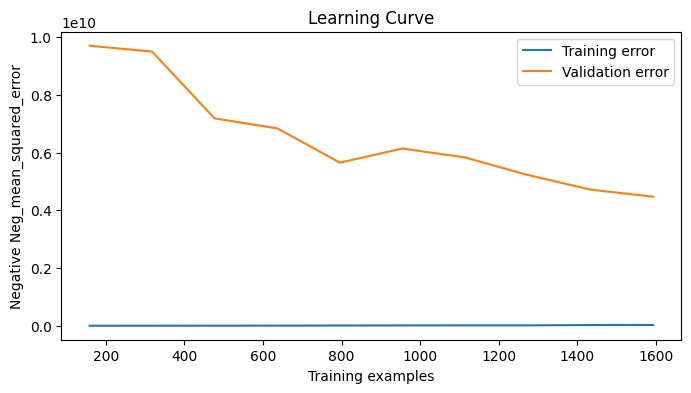

In [128]:
# XGBoost
xgb = XGBRegressor()
xgb_params = {
    'learning_rate': [0.2, 0.3, 0.4, 0.5]
}

xgb_model, xgb_train_sizes, xgb_train_scores, xgb_test_scores = perform_search(xgb, xgb_params, X_train, y_train, X_test, y_test)
xgb_feature_importances = xgb_model.feature_importances_

plot_learning_curve(xgb_model, X_train, y_train, cv=tscv)

In [130]:
## ENSEMBLE MODEL

pred_xgb = xgb_model.predict(X_test)
pred_rf = rf_model.predict(X_test)

weight_rf = 0
ensemble_df = pd.DataFrame(columns=['MSE', 'MAE', 'Weight XGB', 'Weight RF'])
for i in range(0,10):
    weight_xgb = 1 - weight_rf
    
    final_pred = (weight_xgb * pred_xgb) + (weight_rf * pred_rf)
    
    ensemble_mse = mean_squared_error(y_test, final_pred)
    ensemble_mae = mean_absolute_error(y_test, final_pred)

    # store mse, mae and weights in a dataframe 
    ensemble_df.loc[i] = [f'{ensemble_mse:.2f}', ensemble_mae, weight_xgb, weight_rf]

    weight_rf += 0.1
    

ensemble_df.sort_values(by='MSE')

,MSE,MAE,Weight XGB,Weight RF
9,2584525454.09,12702.031717,0.1,0.9
8,2603759210.98,12848.620678,0.2,0.8
7,2632773440.37,13018.612753,0.3,0.7
6,2671568226.92,13214.108322,0.4,0.6
5,2720143426.63,13429.956298,0.5,0.5
4,2778499188.91,13659.226762,0.6,0.4
3,2846635309.43,13922.770551,0.7,0.3
2,2924552267.48,14244.009954,0.8,0.2
1,3012249368.70,14593.857423,0.9,0.1
0,3109727160.26,14961.954991,1.0,0.0
